In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
import  sqlalchemy 
from scipy.optimize import lsq_linear
from shapely.geometry import MultiLineString

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

pg = open('db_credentials.txt')
db = pg.read()
pg.close()
engine = sqlalchemy.create_engine(db)

LIST OF VALUES
VALUE 1
Roadway Type
DESCRIPTION Street
VALUE 2
DESCRIPTION Highway
VALUE 3
DESCRIPTION Bridge
VALUE 4
DESCRIPTION Tunnel
VALUE 5
DESCRIPTION Boardwalk
VALUE 6
DESCRIPTION Path/Trail
VALUE 7
DESCRIPTION Step Street
VALUE 8
DESCRIPTION Driveway
VALUE 9
DESCRIPTION Ramp
VALUE 10
DESCRIPTION Alley
VALUE 11
DESCRIPTION Unknown
VALUE 12
DESCRIPTION Non-Physical Street Segment
VALUE 13
DESCRIPTION U-Turn
VALUE 14
DESCRIPTION Ferry Route

VALUE 0
DESCRIPTION Street other than vehicle only street.
VALUE 1
DESCRIPTION Railroad
VALUE 2
DESCRIPTION Water Edge / Shoreline
VALUE 3
DESCRIPTION Census Block Boundary
VALUE 5
DESCRIPTION Paper Street: This is a legally mapped, but unbuilt street. Such streets are
common in areas of Staten Island anticipating development. May exist in all boroughs.
VALUE 6
DESCRIPTION Private Street: This is a physically existing street which is not owned by the
City and is not officially mapped. For example, streets in the Fort Totten and Breezy Point
sections of Queens.
VALUE 7
DESCRIPTION District Boundary: Physically non-existent boundary for a community district, a
police precinct, or a fire company.
VALUE 8
DESCRIPTION Physical Non-Street Boundary: Physically existing un-addressable boundary
(such as a rock wall cemetery edge).
VALUE 9
DESCRIPTION Paper Street and Census/District Boundary: A legally mapped, but unbuilt
street that also acts as a census block or district boundary.
VALUE A
DESCRIPTION Alley: a narrow street or passageway between and behind city buildings.
VALUE W
DESCRIPTION Path, Non-Vehicular, Addressable: This is a walking path that contains
addresses. For example, some boardwalks and some walking paths in housing projects.
VALUE C
DESCRIPTION CCO (Corporation Counsel Opinion). A CCO is an opinion by the City's Law
Department that a street area, not owned by the City, has been dedicated for public use,
consistent with the requirements of General City Law, Section 36(2). That allows the City to
use public funds for various improvements and services, including paving of the roadway
and installing sewers. The request usually relates to planned work by the City's Department
of Transportation, Department of Design and Construction, and Department of
Environmental Protection.
VALUE F
DESCRIPTION Ferry Route: A schematic representation of a ferry’s passage through a water
body. Please note that only selected ferry routes required for the bicycle routing within NYC
are included.

SEGTYPE
VALUE B
DESCRIPTION Both: Segment is both generic and roadbed; the center roadbed segment of a
divided roadway containing an odd number of roadbeds.
VALUE C
DESCRIPTION Connector: Segments used to connect adjacent roadbeds of a divided street.
Typically these exist to allow traffic flow from one roadbed to another.
VALUE E
DESCRIPTION Entrance/Exit Ramp: Connects a highway to a different street or highway.
VALUE F
DESCRIPTION Faux Segment: These are used when a street or ramp physically ends at a
roadbed, but connectivity needs to be maintained with the generic segment.
VALUE G
DESCRIPTION Generic Segment: An imaginary single line representation of a physically
divided street.
VALUE R
DESCRIPTION Roadbed Segment: Depicts physically separated carriageway segments of a
particular street.
VALUE T
DESCRIPTION Terminator: Used to model situations where a divided section of a street
terminates, but the street itself continues.
VALUE U
DESCRIPTION Undivided Street: All other LION segments that do not fall into any of the
above categories.
VALUE S
DESCRIPTION Suppressed: Undivided segment to be suppressed in a generic view of LION

In [2]:
# lion, segmenttyp != G, 
# rw_type != 6, empty, 7, 8, 12, 14, 11, 10

lion_clipped = gpd.read_postgis("SELECT * FROM lion WHERE lboro = 1", engine, geom_col='shape')
taxis_clipped = gpd.read_postgis('SELECT * FROM taxis_2015_man', engine, geom_col='pickup_point')
nodes_clipped = gpd.read_postgis('SELECT * FROM node_man', engine, geom_col='shape')

In [3]:
lion_clipped.head()

,objectid,street,safstreetname,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,specaddr,facecode,seqnum,streetcode,safstreetcode,lgc1,lgc2,lgc3,lgc4,lgc5,lgc6,lgc7,lgc8,lgc9,boe_lgc,segmentid,segcount,locstatus,lzip,rzip,lboro,rboro,l_cd,r_cd,latomicpolygon,ratomicpolygon,lct2010,lct2010suf,rct2010,rct2010suf,lcb2010,lcb2010suf,rcb2010,rcb2010suf,lct2000,lct2000suf,rct2000,rct2000suf,lcb2000,lcb2000suf,rcb2000,rcb2000suf,lct1990,lct1990suf,rct1990,rct1990suf,lassmdist,lelectdist,rassmdist,relectdist,splitelect,lschldist,rschldist,splitschl,lsubsect,rsubsect,sandistind,mapfrom,mapto,borobndry,mh_ri_flag,xfrom,yfrom,xto,yto,arccenterx,arccentery,curveflag,radius,nodeidfrom,nodeidto,nodelevelf,nodelevelt,conparity,twisted,rw_type,physicalid,genericid,nypdid,fdnyid,lblockfaceid,rblockfaceid,legacyid,status,streetwidth_min,streetwidth_max,streetwidth_irr,bikelane,bike_trafdir,active_flag,posted_speed,snow_priority,number_travel_lanes,number_park_lanes,number_total_lanes,carto_display_level,fcc,row_type,llo_hyphen,lhi_hyphen,rlo_hyphen,rhi_hyphen,fromleft,toleft,fromright,toright,join_id,shape_length,shape
0,87351,BATTERY PARK CITY GREENWAY,,0,U,E,N,D,P,DCP,,0139,02225,100102,,01,,,,,,,,,1,0018067,1,,10280,10280,1,1.0,101,101,921,949,317,04,317,04,4004,,4001,,317,01,317,01,9023,,9022,,319,,317,01,65,013,65,013,,None,02,None,,,,12B,12B,,,979011,196844,979120,196810,0,0,,0,0012339,0012375,M,M,,,6,131896.0,119080.0,,,,,0018067,2,NaN,NaN,,1,TW,None,,,,,,None,,,None,None,None,None,0,0,0,0,1013901000000,114.031859,"MULTILINESTRING ((979011.441 196843.914, 97912..."
1,87352,BATTERY PLACE,,0,U,,B,,T,DOT,,0635,00220,112670,,01,,,,,,,,,1,0018123,2,,10280,10280,1,1.0,101,101,949,914,317,04,317,04,4001,,4005,,317,01,317,01,9022,,9027,,317,01,317,01,65,013,65,012,,02,02,None,1A,1A,,12B,12B,,,979279,196556,979377,196798,980048,196383,L,788,0012377,0012380,M,M,,,1,3.0,3.0,,,0212262587,1222601917,0018123,2,42.0,44.0,,,,None,25,C,2,2,4,None,,,50,64,51,63,50,64,51,63,1063501000000,262.777812,"MULTILINESTRING ((979278.645 196555.536, 97929..."
2,87353,BATTERY PLACE,PS 94,0,U,,B,,T,DOT,N,0635,00220,112670,100011,01,,,,,,,,,1,0018123,2,,10280,10280,1,1.0,101,101,949,914,317,04,317,04,4001,,4005,,317,01,317,01,9022,,9027,,317,01,317,01,65,013,65,012,,02,02,None,1A,1A,,12B,12B,,,979279,196556,979377,196798,980048,196383,L,788,0012377,0012380,M,M,,,1,3.0,3.0,,,0212262587,1222601917,0018123,2,42.0,44.0,,,,None,25,C,2,2,4,None,,,None,None,None,None,0,0,0,0,10001101000000N,262.777812,"MULTILINESTRING ((979278.645 196555.536, 97929..."
3,87354,WEST THAMES STREET,,0,U,,B,,T,DOT,,4780,00030,145210,,01,,,,,,,,,1,0018148,1,,10280,10280,1,1.0,101,101,949,100,317,04,317,04,4001,,2003,,317,01,317,01,9022,,9016,,317,01,317,01,65,013,65,014,,02,02,None,1A,1A,,12B,12B,,,979426,197387,979218,197510,0,0,,0,0012398,0012394,M,M,,,1,23.0,19.0,,,1222600637,1222607193,0018148,2,38.0,74.0,,,,None,25,H,1,2,3,None,,,300,398,301,399,300,398,301,399,1478001000000,241.736699,"MULTILINESTRING ((979426.490 197387.106, 97921..."
4,87355,1 PLACE,,0,U,,B,,W,DOT,,2483,00010,110015,,01,02,,,,,,,,1,0161436,1,,10280,10280,1,1.0,101,101,907,914,317,04,317,04,4006,,4005,,317,01,317,01,9026,,9027,,317,01,317,01,65,012,65,012,,02,02,None,1A,1A,,12B,12B,,,979538,196419,979279,196556,0,0,,0,0095550,0012377,M,M,,,1,29.0,110246.0,,,1222606410,1222601914,0161436,2,34.0,38.0,,,,None,25,C,1,2,3,None,,,None,None,None,None,0,0,0,0,1248301020000,293.100274,"MULTILINESTRING ((979537.962 196418.925, 97927..."


In [4]:
taxis_clipped.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_point,dropoff_point,id,dist_to_nn_dropoff,dist_to_nn_pickup
0,1,2015-05-25 15:30:11,2015-05-25 15:42:18,1,3.00,-73.990379,40.756340,1,N,-73.958817,40.781799,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,POINT (986915.372 214831.910),0101000020D70800003FF930C08E622E41C36A86E1705B...,539484,167.019673,87.684076
1,1,2015-05-19 22:56:24,2015-05-19 23:08:14,1,2.50,-73.988289,40.723255,1,N,-74.000862,40.747330,2,11.0,0.5,0.5,0.00,0.0,0.3,12.30,POINT (987496.136 202778.114),0101000020D70800008DB5663D96072E41E35ED020E8D2...,539515,66.760491,39.286552
2,2,2015-05-25 15:45:48,2015-05-25 15:50:00,6,0.97,-73.965752,40.762321,1,N,-73.955872,40.767860,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,POINT (993737.534 217012.855),0101000020D7080000CCC98404F3682E4111C4F6C7C0BC...,539550,40.883442,116.285676
3,2,2015-05-19 23:08:16,2015-05-19 23:17:56,2,2.13,-73.986168,40.751938,1,N,-73.979088,40.776600,1,9.5,0.5,0.5,3.24,0.0,0.3,14.04,POINT (988082.386 213228.216),0101000020D7080000C4CB49C3B3362E414777F4542E20...,539559,71.441023,107.804293
4,1,2015-05-19 23:08:18,2015-05-19 23:23:59,1,4.80,-73.941689,40.843498,1,N,-73.970970,40.793209,1,17.5,0.5,0.5,2.00,0.0,0.3,20.80,POINT (1000383.847 246591.917),0101000020D7080000A911C45440482E412C6440D14DDD...,539565,52.936905,27.111266


(array([4.42403e+05, 3.45930e+05, 6.99550e+04, 2.85910e+04, 1.04560e+04,
        4.21100e+03, 1.12900e+03, 1.80000e+01, 2.00000e+00, 1.00000e+00]),
 array([4.96568769e-02, 7.33803239e+01, 1.46710991e+02, 2.20041658e+02,
        2.93372325e+02, 3.66702992e+02, 4.40033659e+02, 5.13364326e+02,
        5.86694993e+02, 6.60025660e+02, 7.33356327e+02]),
 <a list of 10 Patch objects>)

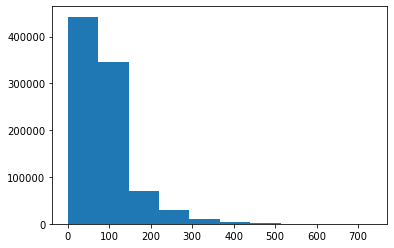

In [5]:
plt.hist(taxis_clipped['dist_to_nn_pickup'])

(array([3.81602e+05, 3.33581e+05, 1.05604e+05, 5.31240e+04, 2.02250e+04,
        7.18800e+03, 1.36600e+03, 3.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.67644779e-01, 7.49767782e+01, 1.49785912e+02, 2.24595045e+02,
        2.99404179e+02, 3.74213312e+02, 4.49022445e+02, 5.23831579e+02,
        5.98640712e+02, 6.73449846e+02, 7.48258979e+02]),
 <a list of 10 Patch objects>)

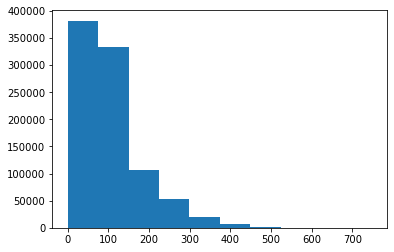

In [6]:
plt.hist(taxis_clipped['dist_to_nn_dropoff'])

In [7]:
lion_clipped['nodeidfrom'] = lion_clipped['nodeidfrom'].astype(int)
lion_clipped['nodeidto'] = lion_clipped['nodeidto'].astype(int)

# REVIST THIS: SHOULD DUPLICATES BE DROPPED?  LOOK AT SEGCOUNT IN MAP
# IF THERE ARE DUPLICATES, SELECT WHERE RW_IS NOT ZERO

#lion_filt = lion_clipped.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'], keep='first', inplace=False).reset_index()
#lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
#lion_filt.set_index(['node_low','node_high'], inplace = True)

In [8]:
#lion_filt[lion_filt['rw_type'] == 6]
#list(lion_clipped.columns)
#n = (lion_filt['rw_type'] == 6).to_numpy()
#lion_filt.iloc[n]
#lion_clipped.dtypes #[lion_clipped['rw_type'] == 6]

lion_clipped['feature_filt'] = lion_clipped.apply(lambda x : (x['featuretyp'].strip() == '0') # street
                                            and ((x['rw_type'].strip() == '1') # street
                                                 or (x['rw_type'].strip() == '2') # highway
                                                 or (x['rw_type'].strip() == '3') # bridge
                                                 or (x['rw_type'].strip() == '4') # tunnel
                                                 or (x['rw_type'].strip() == '9')) # ramp
                                            and (x['segmenttyp'] != 'G') # generic
                                            and (x['segmenttyp'] != 'F') # faux
                                            and (x['trafdir'] != 'P') # pedestrian 
                                                  ,axis = 1) 

<ipython-input-9-0a273b673bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],


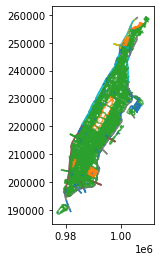

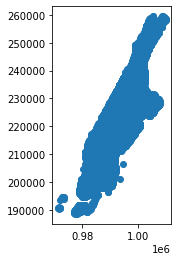

In [9]:
lion_filt = lion_clipped[lion_clipped['feature_filt']]
lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],
                          keep='first', inplace = True)
lion_filt.reset_index(inplace = True)
lion_filt.plot(column='posted_speed')
nodes_clipped.plot()

for each node, find all segments with the same nodeto
for each of those segments, find nodelevelt
if not all nodelevelt are equal, delete this node

find all segments with node from this node
get the node to of these segments
create edge with weight of seg_length of both roads

In [10]:
nodes_clipped

,objectid,nodeid,vintersect,shape
0,11544,12242,,POINT (977028.605 188715.487)
1,11546,12244,,POINT (977720.798 188478.034)
2,11547,12245,,POINT (977302.692 189687.615)
3,11548,12246,,POINT (977563.185 189326.973)
4,11549,12247,,POINT (977599.818 189396.812)
...,...,...,...,...
15422,132590,9054617,,POINT (1000753.672 241714.669)
15423,132591,9054618,,POINT (1000782.785 241767.131)
15424,132592,9054619,,POINT (1000792.767 241763.215)
15425,132593,9054620,,POINT (1000762.379 241710.028)


In [11]:
nodes_clipped['nodeid'] = nodes_clipped['nodeid'].astype(int)
#nodes_clipped.set_index('nodeid', inplace = True)
print(nodes_clipped['nodeid'].max())
node_new = nodes_clipped['nodeid'].max() + 1

9054620


In [12]:
lion_index = lion_filt.index

for i in nodes_clipped.index:
    cur_id = nodes_clipped.loc[i,'nodeid']
    segs_to = lion_filt.loc[lion_filt['nodeidto'] == cur_id,:]
    levels = segs_to['nodelevelt'].unique()
    if len(levels) > 1:
        for l in levels:
            locs_to = (lion_filt['nodeidto'] == cur_id) & (lion_filt['nodelevelt'] == l)
            lion_filt.loc[locs_to, 'nodeidto'] = node_new
            
            locs_from = (lion_filt['nodeidfrom'] == cur_id) & (lion_filt['nodelevelf'] == l)
            lion_filt.loc[locs_from, 'nodeidfrom'] = node_new
            
            node_new = node_new + 1

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)

<ipython-input-13-3ffca3cc4ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
<ipython-input-13-3ffca3cc4ae3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)


In [14]:
# lion_filt = lion_filt[(lion_filt['nodeidto'] != -1) & (lion_filt['nodeidfrom'] != -1)]
# lion_filt.plot()

In [15]:
# lion_filt['velocity'] = 0
# lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
# lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))
# lion_filt[['seg_id','shape_wkt','velocity','nodeidto','nodeidfrom']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
#                                        dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [16]:
def getDGedges(row):
    if row['trafdir'] == 'T':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']}), (row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'W':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'A':
        return [(row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    else:
        print(row['trafdir'])
        raise Exception('TRAFDIR DID NOT PROCESS')

lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
lion_filt.set_index(['node_low','node_high'], inplace = True)
lion_filt['seg_id'] = np.arange(lion_filt.shape[0])

<ipython-input-16-be0b62834e0f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
<ipython-input-16-be0b62834e0f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['seg_id'] = np.arange(lion_filt.shape[0])


In [17]:
#lion_filt.loc[(20868,9052926),:]

In [18]:
to_unique = lion_filt['nodeidto'].unique()
from_unique = lion_filt['nodeidto'].unique()
all_unique = np.concatenate((to_unique, from_unique))
unique_only = np.unique(all_unique)

In [19]:
print(len(to_unique))
print(len(from_unique))
print(len(all_unique))
print(len(unique_only))
print(unique_only.max())

12544
12544
25088
12544
9055888


In [20]:
G = nx.DiGraph()
G.add_nodes_from(all_unique)
for i,row in lion_filt.iterrows():
    G.add_edges_from(row['DG_node'])

In [ ]:
from sqlalchemy.dialects.postgresql import ARRAY, INTEGER, DOUBLE_PRECISION
test = pd.DataFrame(columns = ['nodeidfrom', 'nodeidto', 'nodes', 'seg_ids', 'seg_lengths',
                               'seg_shapes', 'rw_types', 'total_length', 'rw_start', 'rw_end'])

if(engine.has_table('paths')):
    engine.execute('DROP TABLE paths')

###############
# REMEMBER TO DROP TABLE BEFORE RUNNING
###############



for i,inode in enumerate(all_unique):
    print(i)
    for j,jnode in enumerate(all_unique):
        if inode != jnode:
            try:
                p = nx.dijkstra_path(G, inode, jnode, weight = 'weight')
                path_int = [int(pp) for pp in p]

                p_seg_ids = []
                p_seg_lengths = []
                p_seg_shapes = []
                p_rw_types = []
                for i in np.arange(1,len(p)):
                    nodes_temp = [p[i], p[i-1]]
                    node_min = min(nodes_temp)
                    node_max = max(nodes_temp)
                    row = lion_filt.loc[(node_min,node_max)]
                    #lion_filt.loc[(node_min,node_max),'path_count'] = lion_filt.loc[(node_min,node_max),'path_count'] + 1
                    p_seg_ids.append(int(row['seg_id']))
                    p_seg_lengths.append(float(row['shape_length']))
                    p_rw_types.append(int(row['rw_type'][0].strip()))
                    for shape in row['shape']:
                        p_seg_shapes.append(shape[0])

                test.at[0,:] = {'nodeidfrom' : int(inode),
                                'nodeidto' : int(jnode),
                                'nodes' : path_int,
                               'seg_ids' : p_seg_ids,
                               'seg_lengths' : p_seg_lengths,
                               'seg_shapes' : WKTElement(MultiLineString(p_seg_shapes),srid=2263),
                               'rw_types' : p_rw_types,
                               'total_length' : np.array(p_seg_lengths).sum(),
                               'rw_start' : p_rw_types[0],
                               'rw_end' : p_rw_types[-1]}
                test.to_sql('paths', engine, if_exists = 'append',
                            dtype = {'nodes' : ARRAY(INTEGER), 
                                     'seg_ids' : ARRAY(INTEGER),
                                     'seg_lengths' : ARRAY(DOUBLE_PRECISION),
                                     'seg_shapes' : Geometry('MULTILINESTRING', srid=2263),
                                    'rw_types' : ARRAY(INTEGER)})
            except:
                test.at[0,:] = {'nodeidfrom' : int(inode),
                                'nodeidto' : int(jnode),
                                'total_length' : -1}
                test.to_sql('paths', engine, if_exists = 'append')
            break
    break

0


<ipython-input-102-1a25a27f3639>:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  row = lion_filt.loc[(node_min,node_max)]


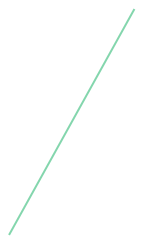

In [82]:
from shapely.geometry import LineString
LineString(p_seg_shapes[0])

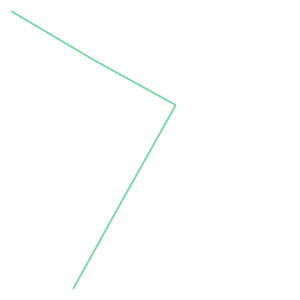

In [83]:
from shapely.ops import linemerge 

MultiLineString(p_seg_shapes)

In [71]:
#test.drop(columns='seg_shapes', inplace = True)
test

,nodeidfrom,nodeidto,nodes,seg_ids,seg_lengths,rw_types
0,12380,12394,"[12380, 12383, 12399, 12398, 12394]","[6496, 1978, 2546, 1]","[259.416003850283, 280.444742756129, 244.37900...","[1, 1, 1, 1]"


In [23]:
create = """CREATE TABLE paths (
    id serial PRIMARY KEY,
    nodeidfrom integer,
    nodeidto integer,
    nodes integer []
    );"""
print(create)

CREATE TABLE paths (
    id serial PRIMARY KEY,
    nodeidfrom integer,
    nodeidto integer,
    nodes integer []
    );


In [3]:
#engine.execute('SELECT * FROM paths')

In [4]:
#engine.execute('INSERT INTO paths (nodeidfrom, nodeidto, nodes) VALUES (8,9,[1,2,3])')

In [21]:
test_paths = pd.read_sql("SELECT * FROM paths", engine)
test_paths.loc[0,'nodes']

[1, 2, 3, 4]

In [ ]:
lion_filt[['seg_id','shape_wkt','velocity','path_count','nodeidfrom','nodeidto']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
                                       dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [ ]:
paths_all = dict(nx.all_pairs_dijkstra_path(G,weight = 'weight'))


In [24]:
taxis_clipped = taxis_clipped[taxis_clipped['nn_pickup'] != taxis_clipped['nn_dropoff']]
taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
taxis_clipped['trip_time'] = taxis_clipped.apply(lambda x: (x['datetime_dropoff']-x['datetime_pickup']).seconds, axis = 1)

<ipython-input-24-31807cac3a99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
<ipython-input-24-31807cac3a99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
<ipython-input-24-31807cac3a99>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [25]:
# ADD FIRST SEGMENT TYPE AND LAST SEGMENT TYPE TO THIS
# NO PICKUPS/DROPOFFS ON TUNNELS, BRIDGES, OR HIGHWAYS
lion_filt.loc[:,'path_count'] = 0

def getPathData(p):
    p_seg_ids = []
    p_seg_lengths = []
    p_seg_shapes = []
    p_rw_types = []
    for i in np.arange(1,len(p)):
        nodes_temp = [p[i], p[i-1]]
        node_min = min(nodes_temp)
        node_max = max(nodes_temp)
        row = lion_filt.loc[(node_min,node_max)]
        lion_filt.loc[(node_min,node_max),'path_count'] = lion_filt.loc[(node_min,node_max),'path_count'] + 1
        p_seg_ids.append(int(row['seg_id']))
        p_seg_lengths.append(float(row['shape_length']))
        p_rw_types.append(row['rw_type'])
        for shape in row['shape']:
            p_seg_shapes.append(shape)
    return p_seg_ids, p_seg_lengths, MultiLineString(p_seg_shapes), p_rw_types

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [26]:
taxis_clipped.loc[:,'path'] = '' 
taxis_clipped.loc[:,'path_distance_mi'] = 0
taxis_clipped.loc[:,'seg_ids'] = ''
taxis_clipped.loc[:,'seg_lengths'] = ''
taxis_clipped.loc[:,'path_shape'] = ''
taxis_clipped.loc[:,'rw_types'] = ''

trip_idx = taxis_clipped.index

for i in trip_idx:
    start_node = taxis_clipped.loc[i,'nn_pickup']
    end_node = taxis_clipped.loc[i,'nn_dropoff']
    try:
        path = paths_all[start_node][end_node]
        taxis_clipped.at[i, 'path'] = path
        seg_ids, seg_lengths, path_shape, rw_types = getPathData(path)
        taxis_clipped.loc[i, 'path_distance_mi'] = np.array(seg_lengths).sum()/5280
        taxis_clipped.at[i,'seg_lengths'] = seg_lengths
        taxis_clipped.at[i, 'seg_ids'] = seg_ids
        taxis_clipped.at[i, 'path_shape'] = path_shape
        taxis_clipped.at[i, 'rw_types'] = rw_types
    except:
        # no possible path
        taxis_clipped.loc[i, 'path_distance_mi'] = -1

    
taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()

<ipython-input-26-d19f34ba8a14>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()


In [27]:
bins = np.arange(0,3.4,0.2)
labels = bins[0:-1] + 0.1

taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
lower = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.05)
upper = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.95)
lower_arr = pd.DataFrame(lower).reset_index().to_numpy()
upper_arr = pd.DataFrame(upper).reset_index().to_numpy()


from scipy.interpolate import UnivariateSpline
spl_lower = UnivariateSpline(lower_arr[:,0],lower_arr[:,1])
spl_upper = UnivariateSpline(upper_arr[:,0],upper_arr[:,1])

taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
taxis_clipped['trip_time_p95'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_upper(x)))

<ipython-input-27-2ae523d8a3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
<ipython-input-27-2ae523d8a3b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
<ipython-input-27-2ae523d8a3b9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [28]:
taxis_clipped['filt'] = taxis_clipped.apply(lambda x : 
                                            (x['trip_distance'] >= 0.5) 
                                            and (x['trip_distance'] <= 2) 
                                            and (x['trip_time'] >= x['trip_time_p5']) 
                                            and (x['trip_time'] <= x['trip_time_p95']) 
                                            and (x['dist_error'] < 0.2)
                                            and (x['path_distance_mi'] != -1)
                                            and (x['dist_to_nn_dropoff'] < 400)
                                            and (x['dist_to_nn_pickup'] < 400)
                                            and (x['rw_types'][0].strip() == '1')
                                            and (x['rw_types'][-1].strip() == '1'), axis = 1)

taxis_filt = taxis_clipped[taxis_clipped['filt']].reset_index()

<ipython-input-28-d2c68c17a214>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxis_clipped['filt'] = taxis_clipped.apply(lambda x :


In [29]:
taxis_filt['path_shape_wkt'] = taxis_filt['path_shape'].apply(lambda x : WKTElement(x,srid=2263))
taxis_filt[['index','id','nn_pickup',
            'nn_dropoff','path_shape_wkt',
           'pickup_longitude','pickup_latitude',
           'dropoff_longitude','dropoff_latitude']].to_sql('taxi_paths', engine, if_exists='replace', index=False,
                                       dtype={'path_shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

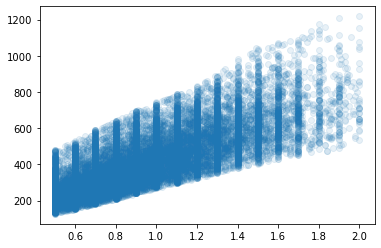

In [30]:
plt.scatter(taxis_filt['trip_distance'],taxis_filt['trip_time'], alpha = 0.1)

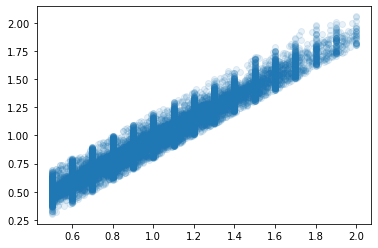

In [31]:
plt.scatter(taxis_filt['trip_distance'],taxis_filt['path_distance_mi'], alpha = 0.1)

In [32]:
#lion_filt['posted_speed'].astype(int)#pow(-1)
#pd.to_numeric(lion_filt['posted_speed'])
#lion_filt.drop(columns = ['shape_wkt'], inplace = True)

lion_filt.replace(to_replace = '  ', value = {'posted_speed' : '50'}, inplace = True)
lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-32-f16cb63c163b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)


In [33]:
trip_filt_idx = taxis_filt.index
num_segments = lion_filt.shape[0]
A = np.zeros([len(trip_filt_idx), num_segments])

for i in trip_filt_idx:
    seg_coefs = np.zeros(num_segments)
    seg_coefs[taxis_filt.loc[i,'seg_ids']] = taxis_filt.loc[i,'seg_lengths']
    A[i] = seg_coefs

In [34]:
b = taxis_filt['trip_time'] 
lb = lion_filt['vel_ub'] # 85 mph
ub = np.ones(num_segments)*0.7 # 1 mph

x = lsq_linear(A, b, bounds = (lb, ub), verbose = 2, max_iter = 100)

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         2.6498e+09                                    7.89e+07    
       1         5.2025e+08      2.13e+09       4.93e+00       1.89e+07    
       2         1.5146e+08      3.69e+08       2.39e+00       4.05e+06    
       3         1.2392e+08      2.75e+07       2.06e-01       7.22e+06    
       4         1.1561e+08      8.31e+06       8.24e-01       4.98e+06    
       5         1.1460e+08      1.01e+06       1.16e-01       4.71e+06    
       6         1.1410e+08      4.96e+05       3.05e-02       8.83e+05    
       7         1.0666e+08      7.44e+06       1.13e+00       4.40e+05    
       8         1.0468e+08      1.99e+06       6.35e-01       3.09e+05    
       9         1.0394e+08      7.37e+05       6.60e-02       6.41e+06    
      10         1.0374e+08      2.02e+05       1.13e-01       6.04e+06    
      11         1.0357e+08      1.66e+05       1.50e-02       5.57e+05    
      12    

In [40]:
x

 active_mask: array([0, 0, 0, ..., 0, 0, 0])
        cost: 99484342.91569209
         fun: array([ 22.68417253, -24.79711406,  73.26808243, ...,  51.41882788,
       108.85508824,  55.36555744])
     message: 'The maximum number of iterations is exceeded.'
         nit: 100
  optimality: 58728.41996927385
      status: 0
     success: False
           x: array([0.03424698, 0.11636364, 0.08469496, ..., 0.04572889, 0.03279213,
       0.03282523])

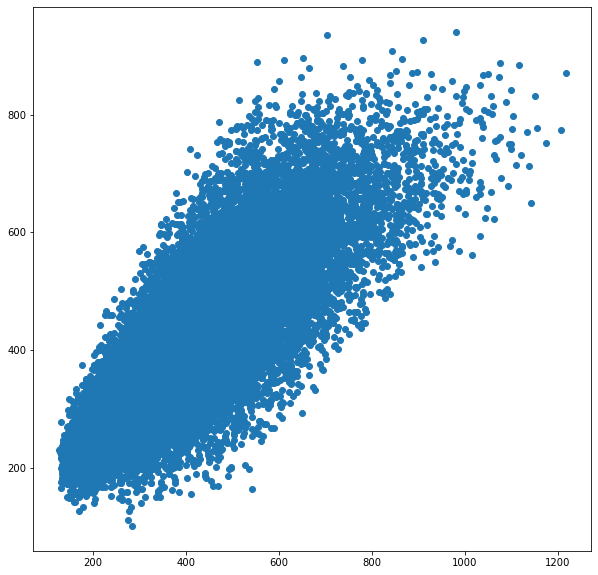

In [41]:
pred = np.matmul(A, x['x'])

plt.figure(figsize=(10,10))
plt.scatter(b, pred)

(array([142.,  64.,  42.,  37.,  50.,  35.,  44.,  45.,  51.,  33.,  62.,
         60.,  44.,  28.,  37.,  35.,  26.,  33.,  25.,  24.,  26.,  19.,
         16.,  22.,  14.,  13.,  13.,  15.,  14.,   5.,  15.,  12.,   9.,
         20.,  19.,  11.,  32.,  25.,  51.,  11.,  16.,  14.,  14.,  29.,
         30.,  45.,  83., 138., 289.,  27.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   3.,   1.,   0.,   0.,   2.,   1.,   4.,
          1.]),
 array([ 0.97402597,  1.37888586,  1.78374575,  2.18860563,  2.59346552,
         2.9983254 ,  3.40318529,  3.80804518,  4.21290506,  4.61776495,
         5.02262484,  5.42748472,  5.83234461,  6.23720449,  6.64206438,
         7.04692427,  7.45178415,  7.85664404,  8.26150392,  8.66636381,
         9.0712237 ,  9.47

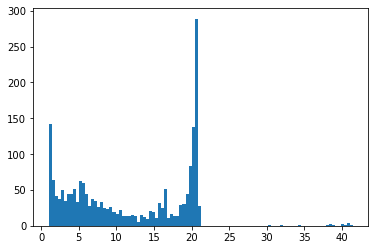

In [42]:
plt.hist((1/x['x'])*(1/5280)*3600, bins = 100)

In [43]:
lion_filt['velocity'] = (1/x['x'])*(1/5280)*3600
lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))

<ipython-input-43-5796603dc0a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['velocity'] = (1/x['x'])*(1/5280)*3600
<ipython-input-43-5796603dc0a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))


In [44]:
lion_filt[['seg_id','shape_wkt','velocity','path_count','nodeidfrom','nodeidto']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
                                       dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})